# Jacobo Casado de Gracia. 
Creación de los dataframes para el Proyecto de Fin de Grado de clasificación de diatomeas. Se utiliza validación cruzada en 3 folds para crear los subconjuntos de entrenamiento y validación, con un 20% de los datos guardados para el conjunto de test.

Importación de las librerías necesarias para crear los dataframes de entrenamiento, validación y test

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

Al hacerse en Google Colab, necesitamos montar el disco donde están las imágenes. En mi caso, ha sido en mi cuenta de Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Mounted at /content/drive


# **Funciones necesarias para crear los dataframes**
Antes de cada función se explica brevemente qué realiza.


# Función get_dataframe
Función que, a partir de una ruta dada por sdir, crea un dataframe de dos columnas: 'filepaths', con la ruta de cada imagen, y 'labels', la clase correspondiente a esa imagen. El parámetro "dir" se ha añadido para darle un nombre al dataframe. No es importante. \\
Dentro del método se checkea la validez de las imágenes. \\
**La estructura de sdir debe de ser una carpeta que contenga dentro subcarpetas, una por cada clase del modelo. En cada subcarpeta están las imágenes de esa clase. En caso contrario, la función fallará.**


In [3]:
def get_dataframe(sdir, dir):

    ht  = 0
    wt = 0
    samples = 0
    sample_count = 10
    filepaths = []
    labels = []
    classlist = os.listdir(sdir)


    for klass in classlist:

        classpath = os.path.join(sdir, klass)
        flist = os.listdir(classpath)

        for i, f in enumerate(flist):

            fpath=os.path.join(classpath,f)

            try: 
                img = plt.imread(fpath)
                shape = img.shape
                filepaths.append(fpath)
                labels.append(klass)  


                if i < sample_count:
                    img = plt.imread(fpath)               
                    ht += img.shape[0]
                    wt += img.shape[1]
                    samples += 1
            except:
                print ('El archivo ', fpath, ' es una imagen inválida. \nNo se incluirá en el dataframe. ')

    filepaths = pd.Series(filepaths, name='filepaths')
    labels = pd.Series(labels, name='labels')

    df = pd.concat([filepaths, labels], axis = 1)
    class_count = len(df['labels'].unique())
    print('El df tiene ', class_count, ' clases.')

    groups = df.groupby('labels')
    print('{0:^30s} {1:^13s}'.format('Clase', 'Cantidad de imágenes'))


    for label in df['labels'].unique():
          group = groups.get_group(label)      
          print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

    wave = wt/samples
    have = ht/samples
    aspect_ratio = have/wave
    print ('Altura media: ' ,have, '  Anchura media: ', wave, '  Aspect ratio medio: ', aspect_ratio)
    
    return df

# Función trim
Función que recorta un dataframe "df" de manera que todas las imágenes de cada clase tienen como mínimo min_size (en caso de tener menos, esa clase se elimina) y como máximo max_size (las imágenes sobrantes de recortar cada clase van a spare_df, que es una de las salidas del método. La otra salida es el dataframe trimeado).

In [4]:
def trim (df, max_size, min_size):
    
    column = 'labels'
    df = df.copy()
    original_class_count = len(list(df[column].unique()))   
    sample_list = [] 
    spare_list = []
    groups = df.groupby(column)
    
    for label in df[column].unique(): 
        
        group = groups.get_group(label)
        sample_count = len(group)    
        
        if sample_count > max_size:
            strat = group[column]
            samples, spare_data = train_test_split(group, train_size = max_size, shuffle = True, random_state = 123, stratify = strat)            
            sample_list.append(samples)
            spare_list.append(spare_data)
            
        elif sample_count >= min_size:
            sample_list.append(group)
            
    df = pd.concat(sample_list, axis = 0).reset_index(drop = True)
    spare_df = pd.concat(spare_list, axis = 0).reset_index(drop = True)
    
    final_class_count = len(list(df[column].unique())) 
    
    if final_class_count != original_class_count:
        print ('El dataframe se ha reducido. Número de clases original: ', original_class_count,' Número de clases actual: ', final_class_count)
        
        
    print("Dataframe trimeado:")
    groups = df.groupby('labels')
    print('{0:^30s} {1:^13s}'.format('Clase', 'Número de imágenes'))
    
    for label in df['labels'].unique():
          group = groups.get_group(label)      
          print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
    
    print("Dataframe spare:")
    groups = spare_df.groupby('labels')
    print('{0:^30s} {1:^13s}'.format('Clase', 'Número de imágenes'))
        
    for label in spare_df['labels'].unique():
      group = groups.get_group(label)      
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

    return df, spare_df


# Función balance
Función que balancea el dataframe "df" de manera que todas las imágenes tienen max_samples. Mediante aumento de datos se generan imágenes artificiales, de tamaño "image_size" y se almacenan en la carpeta aug_fold_i, donde i es el parámetro "fold_var". \\
Personalizar el aumento de datos realizado dentro del método si se desea. \\
Las imágenes aumentadas se añaden al dataframe df.

In [5]:
def balance(df, max_samples, min_samples, working_dir, image_size, fold_var):
    
    column = 'labels'
    
    df = df.copy()       

    aug_dir = os.path.join(working_dir, ('aug_fold_' + str(fold_var)))
    
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
        
    os.mkdir(aug_dir)
    
    for label in df['labels'].unique():    
        dir_path = os.path.join(aug_dir, label)    
        os.mkdir(dir_path)
        
    total = 0
    gen = ImageDataGenerator(rotation_range = 180, width_shift_range = .2, height_shift_range = .2, zoom_range = .1, horizontal_flip=True, vertical_flip = True, brightness_range=[0.7,1.3])
    
    groups=df.groupby('labels') # Agrupar por cada clase
    
    for label in df['labels'].unique():  # Por cada clase            
        group = groups.get_group(label)  # Nos quedamos con las imágenes de esa clase
        sample_count = len(group)   # Cuántas imágenes hay en esa clase
        if sample_count < max_samples: # Si hay menos imágenes:
            
            aug_img_count = 0
            delta = max_samples-sample_count  # Aumentamos el resto que falta.
            print("Resta de imágenes: ", str(delta))
            target_dir = os.path.join(aug_dir, label)  # Definimos dónde escribir las imágenes.  
            aug_gen = gen.flow_from_dataframe(group,  x_col = 'filepaths', y_col = None, target_size = image_size,
                                            class_mode = None, shuffle = False, 
                                            save_to_dir = target_dir, batch_size = 1, save_prefix = 'aug-', color_mode = 'rgb',
                                            save_format = 'jpg')
            while aug_img_count < delta:
                images = next(aug_gen)            
                aug_img_count += len(images)
                
            total += aug_img_count
            
    print('Imágenes totales creadas debido al aumento de datos:', total)
    
    # Creamos el dataset aumentado y lo unimos al de entrenamiento original.
    if total > 0:
        aug_fpaths = []
        aug_labels = []
        classlist = os.listdir(aug_dir)
        
        for klass in classlist:
            classpath = os.path.join(aug_dir, klass)     
            flist = os.listdir(classpath)    
            
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
                
        Fseries = pd.Series(aug_fpaths, name='filepaths')
        Lseries = pd.Series(aug_labels, name='labels')
        aug_df = pd.concat([Fseries, Lseries], axis = 1)
        df = pd.concat([df,aug_df], axis = 0).reset_index(drop = True)
   
    print (list(df['labels'].value_counts()) )
    return df

# Función show_image_samples
Función que dado un ImageDataGenerator, imprime max_length imágenes de ese ImageDataGenerator en un plot de tamaño "size".

In [6]:
def show_image_samples(gen, max_length, size):
    
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images,labels = next(gen) # Cogemos un batch del datagen
    plt.figure(figsize = (size, size))
    length = len(labels)
    
    if length < max_length:   # Máximo max_length imágenes
        r = length
    else:
        r = max_length
        
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       
        plt.imshow(image) # Mostramos la imagen.
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title("Clase " + class_name, color='black', fontsize = 12)
        plt.axis('off')
        
    plt.show()

# Función plotImages
Función que imprime un array de imágenes images_arr en una matriz de "rows" filas y "imgs_per_row" columnas, donde cada imagen se imprime con un tamaño "size".

In [7]:
def plotImages(images_arr, size, rows, imgs_per_row):

    fig, axes = plt.subplots(rows, imgs_per_row, figsize=(size,size))
    
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")

    fig.subplots_adjust(top = 0.3, bottom=0.01, hspace=0.01, wspace=0.4)
    fig.suptitle("Imágenes generadas a partir de la original con aumento de datos", y=0.3)
    plt.show()


# Carga del dataframe de imágenes sin preprocesar.

El df tiene  44  clases.
            Clase              Cantidad de imágenes
        Achnanthidium              1425     
           Adlafia                  28      
           Amphora                  200     
         Aulacoseira                351     
          Brachysira                104     
           Caloneis                 54      
           Cavinula                 84      
       Chamaepinnularia             31      
          Cocconeis                 350     
          Craticula                 195     
          Cyclotella                263     
         Cymbopleura                233     
          Diadesmis                 21      
           Diatoma                  267     
          Encyonema                 701     
         Encyonopsis                415     
           Eolimna                  428     
           Eunotia                  426     
          Fragilaria                561     
          Frustulia                 136     
          Geissleria   

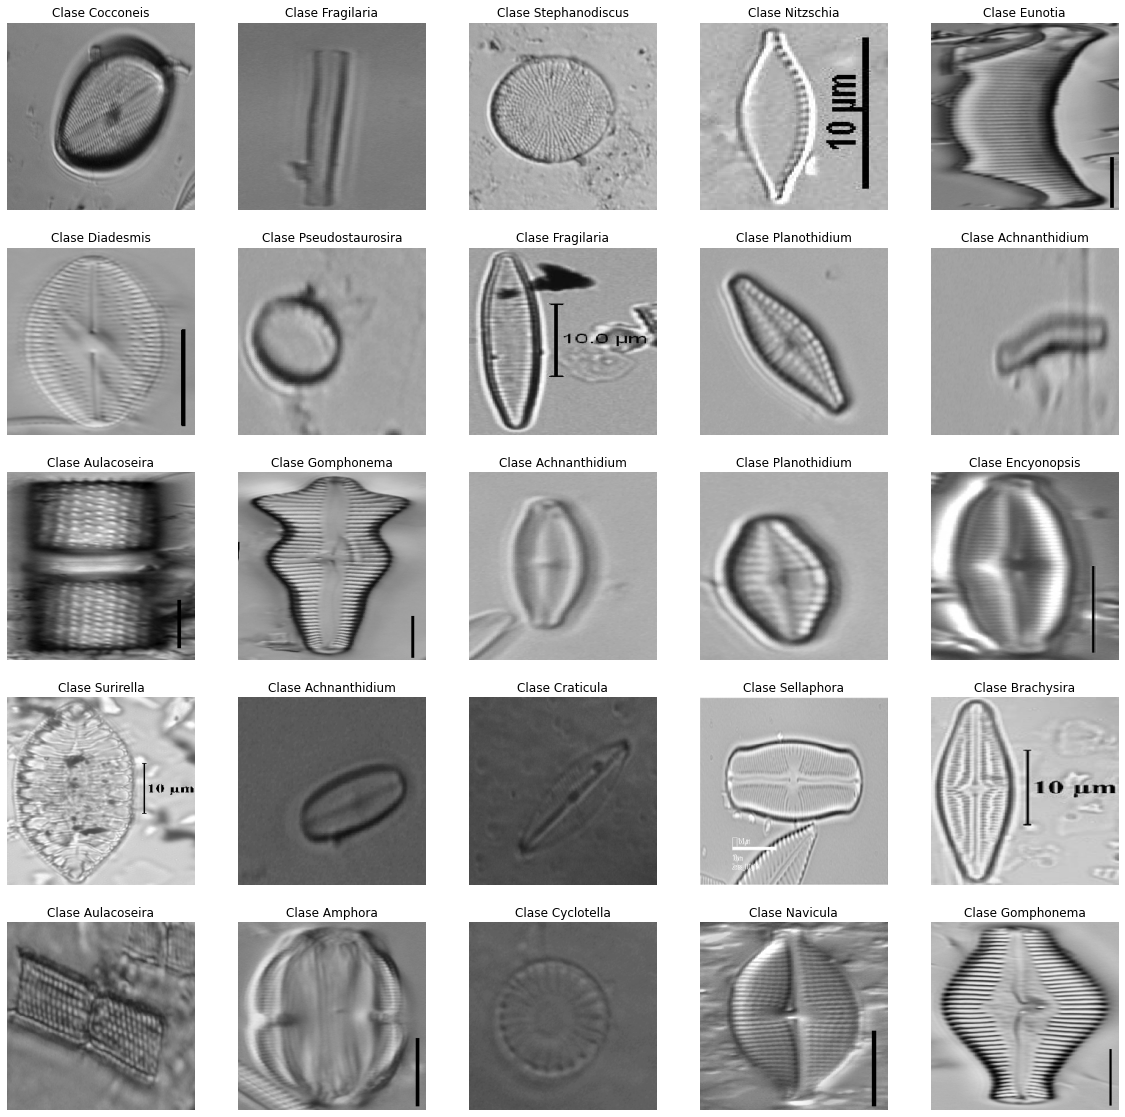

In [8]:
# !unzip -q "/content/drive/MyDrive/data_before_preprocessing.zip" -d "/content/drive/MyDrive/data_before_preprocessing"

sdir= '/content/drive/MyDrive/data_before_preprocessing/' # Path donde se sitúa la carpeta que dentro tiene las subcarpetas de las clases.
dir = 'before_preprocess' # Darle un nombre al dataset.

df = get_dataframe(sdir, dir) # Cargamos el dataframe.

image_gen = ImageDataGenerator()
gen = image_gen.flow_from_dataframe(df, x_col = 'filepaths', y_col = 'labels', 
                                    #target_size = img_size,
                                   class_mode = 'categorical', color_mode = 'rgb', shuffle = True
                                  )
show_image_samples(gen, 25, 20) #Mostramos 25 imágenes.

# Carga del dataframe de imágenes procesado. División en entrenamiento, validación de 3 folds y test.

In [9]:
#!unzip -q "/content/drive/MyDrive/data_big.zip" -d "/content/drive/MyDrive/data_big/"

max_samples = 400 # Número máximo de muestras por clase en entrenamiento.
min_samples = 10 # Número mínimo de muestras necesarias para tener a la clase en cuenta.

sdir= '/content/drive/MyDrive/data_big/' # Path donde se sitúan las imágenes.
dir = 'big' # Darle un nombre al dataset.

img_size = (224,224) # Tamaño de imagen de los datos generados con data augment.

random_state = 123 # Semilla para la reproducibilidad en la partición de datos

balance = False

Cargamos el dataframe con el directorio donde se sitúa la carpeta con las subcarpetas de cada clase.

In [10]:
df = get_dataframe(sdir, dir)

El archivo  /content/drive/MyDrive/data_big/Achnanthidium/Achnanthidium_eutrophilum (1).db  es una imagen inválida. 
No se incluirá en el dataframe. 
El df tiene  44  clases.
            Clase              Cantidad de imágenes
          Craticula                 195     
           Amphora                  200     
           Adlafia                  28      
           Cavinula                 84      
           Caloneis                 54      
        Achnanthidium              1424     
          Brachysira                104     
         Aulacoseira                351     
       Chamaepinnularia             31      
          Cocconeis                 348     
           Diatoma                  267     
         Encyonopsis                409     
          Cyclotella                263     
          Frustulia                 136     
         Cymbopleura                233     
           Eunotia                  426     
          Encyonema                 701     
        

Mostramos algunas imágenes aleatorias de este dataset

Found 10650 validated image filenames belonging to 44 classes.


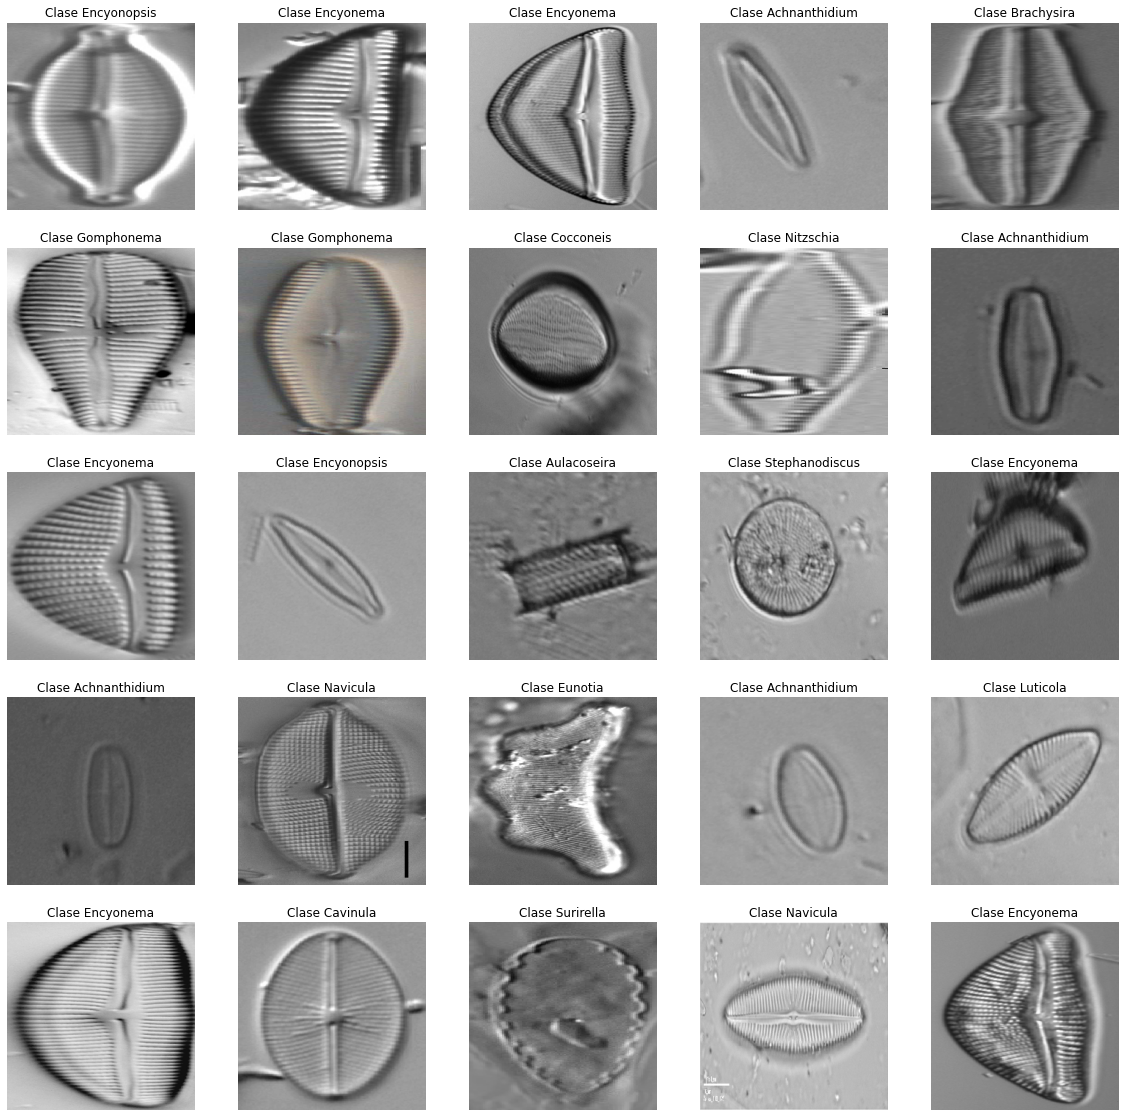

In [11]:
image_gen = ImageDataGenerator()
gen = image_gen.flow_from_dataframe(df, x_col = 'filepaths', y_col = 'labels', 
                                    #target_size = img_size,
                                   class_mode = 'categorical', color_mode = 'rgb', shuffle = True
                                  )
show_image_samples(gen, 25, 20)

Vemos un ejemplo del aumento de datos a una imagen aleatoria del dataset.

Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.


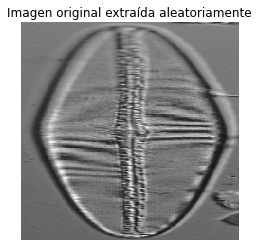

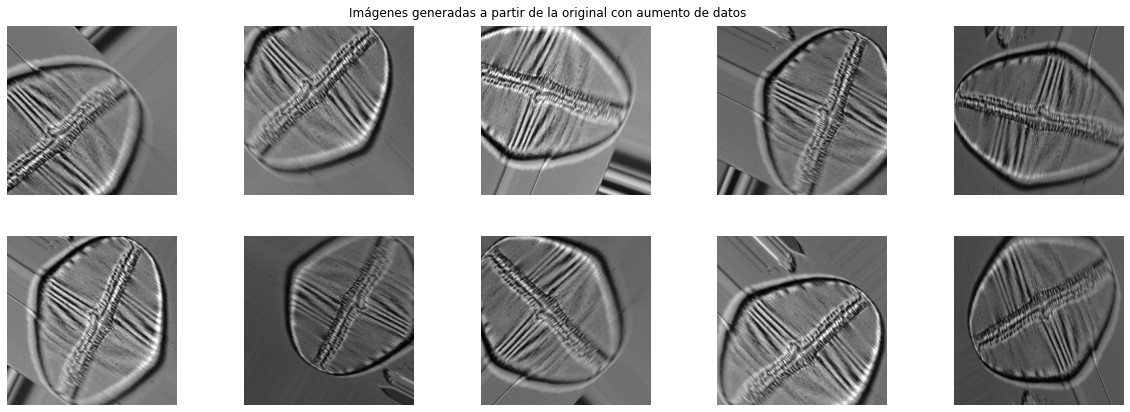

In [12]:
image_gen_aug = ImageDataGenerator(rescale=1./255,rotation_range = 180, width_shift_range = .2, height_shift_range = .2, zoom_range = .1, horizontal_flip=True, vertical_flip = True, brightness_range=[0.7,1.3])
image_gen_normal = ImageDataGenerator(rescale=1./255)

random_img = df.sample()

aug_gen = image_gen_aug.flow_from_dataframe(random_img, x_col = 'filepaths', y_col = 'labels', 
                                    #target_size = img_size,
                                   class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = 1
                                  )

gen = image_gen_normal.flow_from_dataframe(random_img, x_col = 'filepaths', y_col = 'labels', 
                                    #target_size = img_size,
                                   class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = 1
                                  )

plt.imshow(gen[0][0][0])
plt.axis("off")
plt.title("Imagen original extraída aleatoriamente")

rows = 2
imgs_per_row = 5
num_images = 20
augmented_images = [aug_gen[0][0][0] for i in range(rows*imgs_per_row)]
plotImages(augmented_images, num_images, rows, imgs_per_row)

# Creación de los dataframes de entrenamiento, test y validación.
Los dataframes de entrenamiento y validación se subdividen en 3 folds, que se almacenarán en un array training_data y validation_data de 3 elementos cada uno, pertenecientes a cada fold. Además de eso, se guardan en un directorio para cargar los dataframes en el script de entrenamiento y no ejecutar estas funciones de carga de datos de nuevo.

In [13]:
trim_df, spare_df = trim(df, max_samples, min_samples)

train_df, test_df = train_test_split(trim_df, train_size = .8, shuffle = True, random_state = random_state, stratify = trim_df['labels']) 

print('Tamaño del conjunto de ENTRENAMIENTO: ', len(train_df), '  \nTamaño del conjunto de TEST: ', len(test_df))

print("Información del Dataframe de ENTRENAMIENTO:")
classes = list(train_df['labels'].unique())
class_count = len(classes)
groups = train_df.groupby('labels')

print('{0:^30s} {1:^13s}'.format('Clase', 'Número de imágenes'))
for label in train_df['labels'].unique():
      group = groups.get_group(label)      
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

test_df = pd.concat([test_df, spare_df])
test_df.to_pickle("/content/drive/MyDrive/folds/test_df.pkl")

print("Tamaño del conjunto de TEST con las imágenes sobrantes de entrenamiento: ", len(test_df))
test_df.to_pickle("/content/drive/MyDrive/folds/test_df.pkl")

train_df_labels = train_df['labels']
train_df_samples = train_df['filepaths']

stratified_kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = random_state)

train_df_fold = []
valid_df_fold = []

fold_var = 0

for train_index, val_index in stratified_kf.split(train_df_samples, train_df_labels):
    
    print(train_index.size, val_index.size)
    
    print("Número de fold: ", fold_var)

    training_data = train_df.loc[train_df.index[train_index]]
    
    print("Tamaño del conjunto de entrenamiento ANTES DEL BALANCEO en el fold ", fold_var, ": ",  len(training_data))
    
    working_dir = r'/content/drive/MyDrive/' 

    if (balance): # Especificamos si queremos balancear las clases.
      training_data = balance(training_data, max_samples, min_samples, working_dir, img_size, fold_var)
    
    train_df_fold.append(training_data)
    training_data.to_pickle("/content/drive/MyDrive/folds/train_df_fold" + str(fold_var) + ".pkl")

    print("Tamaño del conjunto de entrenamiento DESPUÉS DEL BALANCEO en el fold ", fold_var, ": ",  len(training_data))
    
    validation_data = train_df.loc[train_df.index[val_index]]
    valid_df_fold.append(validation_data)
    validation_data.to_pickle("/content/drive/MyDrive/folds/validation_df_fold" + str(fold_var) + ".pkl")

    print("Tamaño del conjunto de validación en el fold ", fold_var, ": ",  len(validation_data))

    fold_var += 1

El archivo  /content/drive/MyDrive/data_big/Achnanthidium/Achnanthidium_eutrophilum (1).db  es una imagen inválida. 
No se incluirá en el dataframe. 
El df tiene  44  clases.
            Clase              Cantidad de imágenes
          Craticula                 195     
           Amphora                  200     
           Adlafia                  28      
           Cavinula                 84      
           Caloneis                 54      
        Achnanthidium              1424     
          Brachysira                104     
         Aulacoseira                351     
       Chamaepinnularia             31      
          Cocconeis                 348     
           Diatoma                  267     
         Encyonopsis                409     
          Cyclotella                263     
          Frustulia                 136     
         Cymbopleura                233     
           Eunotia                  426     
          Encyonema                 701     
        